## TF-IDF (TERM FREQUENCY - INVERSE DOCUMENT FRECUENCY)

Se realizará un proceso de reconociemnto de palabras clave (keywords) con un modelo TF-IDF previamente entrenado en artículos con etiquetas conocidas. Posteriormente, este modelo podrá ser utilizado para clasificar noticias desconocidas y determinar su temática.

### Imports

In [66]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer

# Ajustamos el nivel de logging a ERROR para ocultar los mensajes de INFO y WARNING
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

### Carga de datos

In [67]:
df = pd.read_csv('../../data/bbc_data.csv')
labeled_articles = defaultdict(list)
labels_idx = {label: idx for idx, label in enumerate(df['labels'].unique())}
y = []

for _, row in df.iterrows():
    y.append(labels_idx[row['labels']])

print(labels_idx)

{'entertainment': 0, 'business': 1, 'sport': 2, 'politics': 3, 'tech': 4}


### Entrenamiento Y Metricas

In [68]:
def plot_accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    cm = confusion_matrix(labels, preds)
    
    cm_df = pd.DataFrame(cm, 
                         index=[label_dict_inverse[i] for i in range(len(label_dict))], 
                         columns=[label_dict_inverse[i] for i in range(len(label_dict))])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='viridis', cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_roc_curve(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    true_vals_bin = label_binarize(labels, classes=list(label_dict.values()))

    # Calcular la curva ROC y el AUC para cada clase
    n_classes = len(label_dict)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # One-hot encode the predicted labels to form predicted probabilities
    encoder = OneHotEncoder(sparse_output=False, categories='auto')
    preds_bin = encoder.fit_transform(np.array(preds).reshape(-1, 1))

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_vals_bin[:, i], preds_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
        class_label = label_dict_inverse[i]
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {class_label}) (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [69]:
def train(X_train, y_train, max_iter=10000):
    model = LogisticRegression(max_iter=max_iter)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_train, X_test, y_train, y_test, label_dict):
    # Train
    train_df = pd.DataFrame({'Metric': ['F1 Score', 'Precision', 'Recall', 'Accuracy'], 'Value': [f1_score(y_train, model.predict(X_train), average='macro'), precision_score(y_train, model.predict(X_train), average='macro'), recall_score(y_train, model.predict(X_train), average='macro'), accuracy_score(y_train, model.predict(X_train))]})
    train_df['Model'] = 'Train'

    # Test   
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    plot_accuracy_per_class(y_pred, y_test, label_dict)
    plot_roc_curve(y_pred, y_test, label_dict)
    
    test_df = pd.DataFrame({'Metric': ['F1 Score', 'Precision', 'Recall', 'Accuracy'], 'Value': [f1, precision, recall, accuracy]})
    test_df['Model'] = 'Test'

    # Combinar los DataFrames
    combined_df = pd.concat([train_df, test_df])
    pivot_df = combined_df.pivot(index='Metric', columns='Model', values='Value')
    return pivot_df

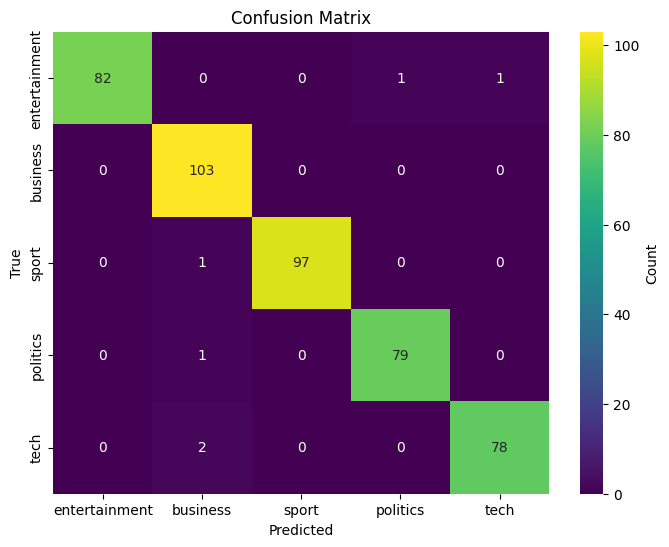

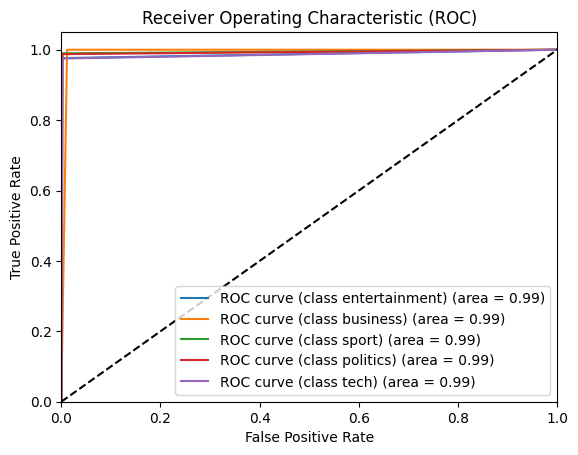

Model,Test,Train
Metric,,
Accuracy,0.986517,0.997191
F1 Score,0.986482,0.997095
Precision,0.987492,0.997017
Recall,0.985697,0.997178


In [70]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['data'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
# Define model and evaluate
model = train(X_train, y_train)
metric_df = evaluate_model(model, X_train, X_test, y_train, y_test, labels_idx)

metric_df